<a href="https://colab.research.google.com/github/rmatrella/BirdsSound/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd "/content/drive/MyDrive/Marino_Matrella"
root = os.getcwd()

Mounted at /content/drive/
[Errno 2] No such file or directory: '/content/drive/MyDrive/Marino_Matrella'
/content


In [ ]:
!pip install -q pydub pyogg spec_augment noisereduce

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install plotly

In [ ]:
import os
import csv
import pyogg
import shutil
import librosa
import IPython
import numpy as np
from PIL import Image
import soundfile as sf
import noisereduce as nr
from scipy.io import wavfile
from pydub import AudioSegment
from pathlib import Path
import plotly.graph_objects as go
from scipy.io.wavfile import read,write
import matplotlib.pyplot as plt
from IPython.display import Audio
from spec_augment import SpecAugment
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data exploration

In [ ]:
train_metadata = pd.read_csv('birds/train_metadata.csv')
train_metadata["primary_label"].value_counts()

barswa     500
wlwwar     500
thrnig1    500
eaywag1    500
comsan     500
          ... 
lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1
Name: primary_label, Length: 264, dtype: int64

<Axes: >

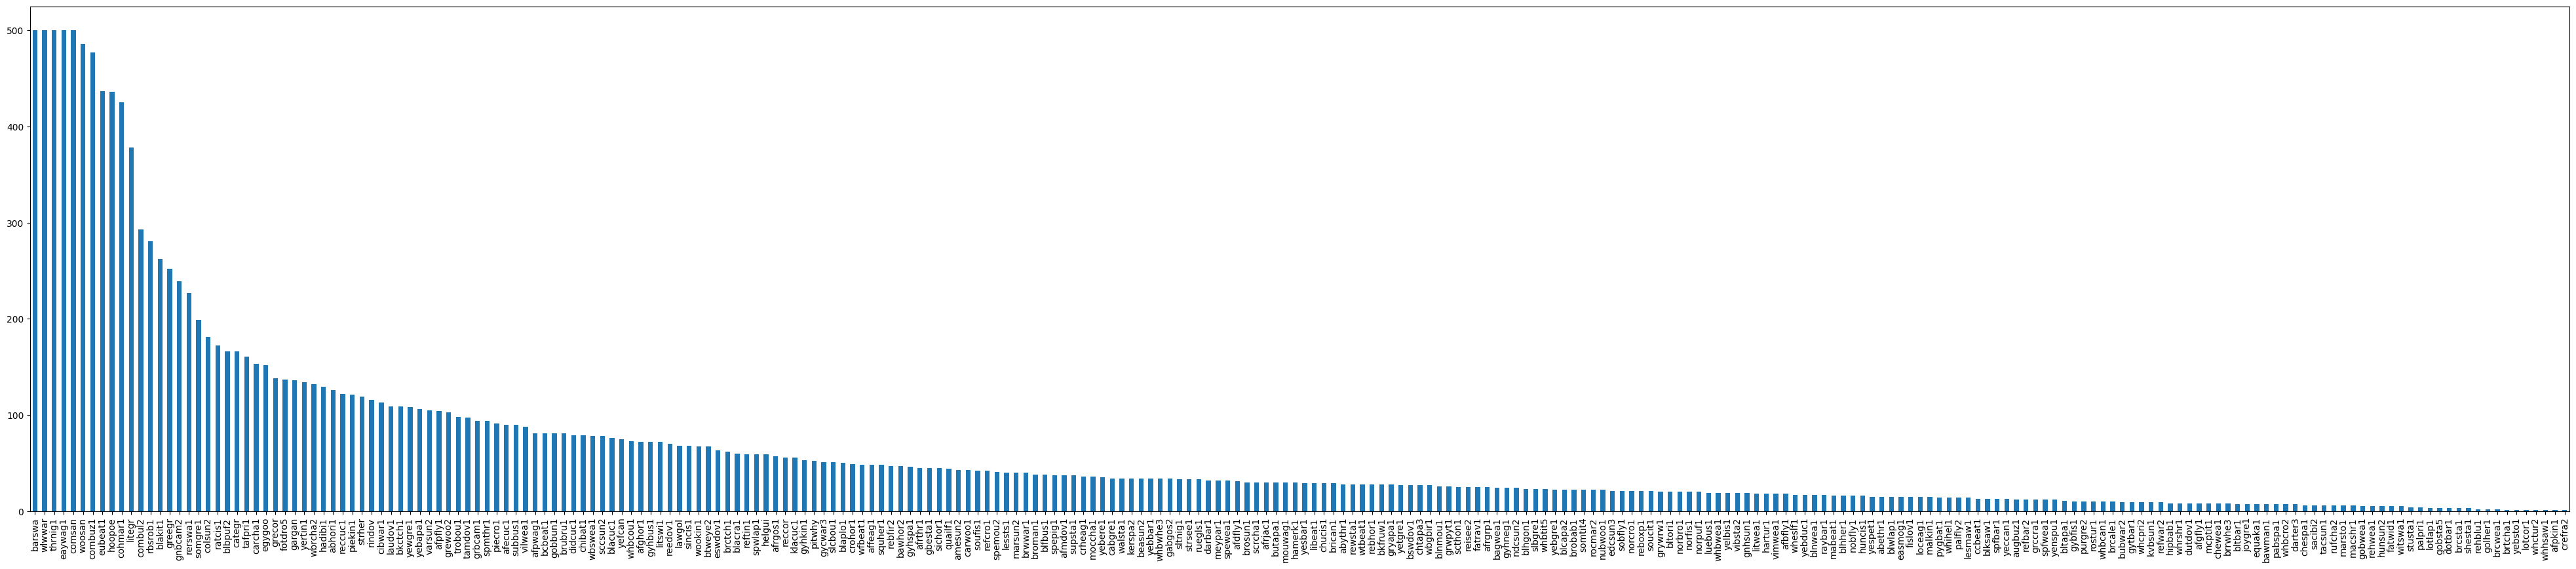

In [ ]:
train_metadata["primary_label"].value_counts().plot(kind='bar', figsize=(50, 10))

In [ ]:
# Load a sample audio files from two different species
audio_abe, sr_abe = librosa.load(root+"/birds/train_audio/abethr1/XC128013.ogg")
audio_abh, sr_abh = librosa.load(root+"/birds/train_audio/abhori1/XC127317.ogg")

In [ ]:
# Play the audio
Audio(data=audio_abe, rate=sr_abe)

In [ ]:
# Play the audio
Audio(data=audio_abh, rate=sr_abh)

# Audio lenght analysis

## Get tot minutes of audio for each specie

In [ ]:
def plot_graph(d, file):
      plt.figure(figsize=(15,6))
      plt.margins(x=0)
      plt.xticks(rotation = 90)
      plt.bar(range(len(d)), list(d.values()), align='center')
      plt.xticks(range(len(d)), list(d.keys()))
      plt.savefig(file+'.png')

      plt.show()

In [ ]:
def get_minutes_all():
  dictionary = {}
  entries = os.listdir('birds/train_audio/')

  for entry in entries: #for each specie (one folder for each one)
      files = os.listdir('birds/train_audio/' + entry)
      time = 0

      #get all the audio for each specie
      for file in files:
          path = 'birds/train_audio/' + entry + '/' + file
          sound, sr = librosa.load(path)
          time += librosa.get_duration(y=sound, sr=sr)

      print(entry, time/60)
      dictionary[entry] = time/60

def csv_minutes_all():
  #sort dict
  sorted_dict = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

  #write dict on .csv file
  with open('all_species_minutes_ordered.csv', 'w') as csv_file:
      writer = csv.writer(csv_file)
      for key, value in sorted_dict.items():
        writer.writerow([key, value])

In [ ]:
# csv_minutes_all()

mins_per_class = {}
with open('all_species_minutes_ordered.csv') as csv_file:
    reader = csv.reader(csv_file)
    print(reader)
    mins_per_class = dict(reader)

mins_per_class = {k: float(v) for k, v in mins_per_class.items()}

print(mins_per_class)

{'thrnig1': 1026.7760151171578, 'wlwwar': 558.7177120181403, 'eubeat1': 514.1357709750569, 'hoopoe': 418.14385563114126, 'combuz1': 414.5536681783826, 'cohmar1': 340.71076946334085, 'barswa': 320.5087377173091, 'eaywag1': 279.19778382464085, 'comsan': 258.7796250944823, 'combul2': 240.80137717309154, 'woosan': 224.7628926681784, 'rbsrob1': 192.64422826908557, 'blakit1': 191.61315117157957, 'litegr': 156.93956916099796, 'grecor': 155.51218594104304, 'somgre1': 147.7206258503401, 'gnbcam2': 133.56971655328803, 'rerswa1': 130.3254671201814, 'lawgol': 120.85533106575966, 'colsun2': 120.74405744520028, 'carcha1': 120.36698412698412, 'categr': 117.99731746031749, 'fotdro5': 116.65373318216167, 'wbrcha2': 109.89139002267574, 'abhori1': 93.86277702191984, 'greegr': 93.83884353741496, 'tamdov1': 89.69187301587301, 'ratcis1': 89.60445427059716, 'egygoo': 86.2944247921391, 'yertin1': 78.9449168556311, 'litswi1': 77.55477399848829, 'blbpuf2': 75.02813151927434, 'reccuc1': 71.98950491307637, 'yewgr

{'thrnig1': 1026.7760151171578, 'wlwwar': 558.7177120181403, 'eubeat1': 514.1357709750569, 'hoopoe': 418.14385563114126, 'combuz1': 414.5536681783826, 'cohmar1': 340.71076946334085, 'barswa': 320.5087377173091, 'eaywag1': 279.19778382464085, 'comsan': 258.7796250944823, 'combul2': 240.80137717309154, 'woosan': 224.7628926681784, 'rbsrob1': 192.64422826908557, 'blakit1': 191.61315117157957, 'litegr': 156.93956916099796, 'grecor': 155.51218594104304, 'somgre1': 147.7206258503401, 'gnbcam2': 133.56971655328803, 'rerswa1': 130.3254671201814, 'lawgol': 120.85533106575966, 'colsun2': 120.74405744520028, 'carcha1': 120.36698412698412, 'categr': 117.99731746031749, 'fotdro5': 116.65373318216167, 'wbrcha2': 109.89139002267574, 'abhori1': 93.86277702191984, 'greegr': 93.83884353741496, 'tamdov1': 89.69187301587301, 'ratcis1': 89.60445427059716, 'egygoo': 86.2944247921391, 'yertin1': 78.9449168556311, 'litswi1': 77.55477399848829, 'blbpuf2': 75.02813151927434, 'reccuc1': 71.98950491307637, 'yewgr

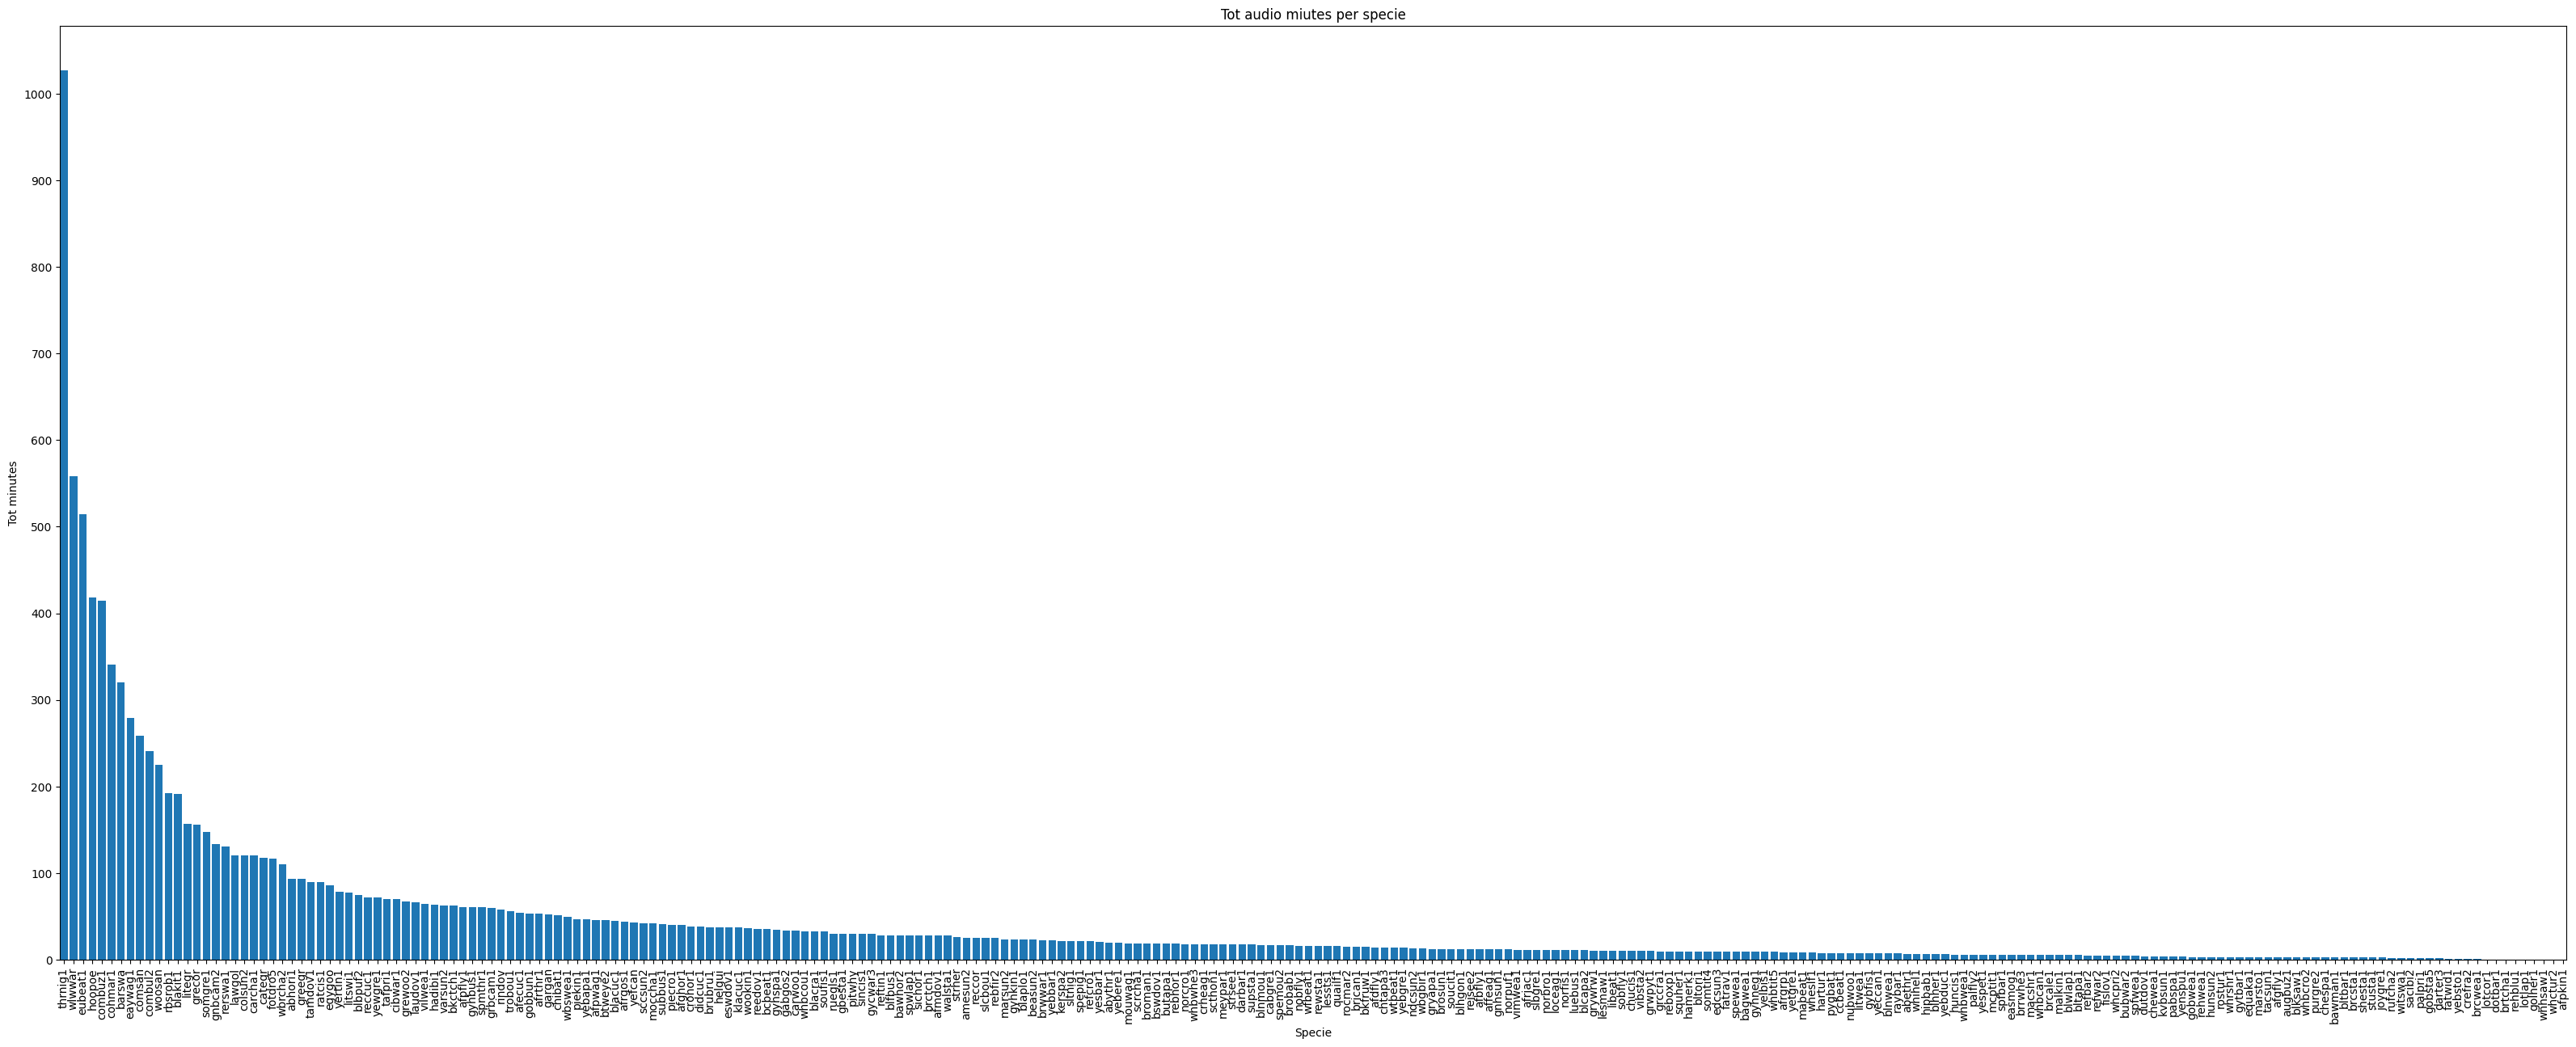

In [ ]:
print(mins_per_class, '\n')

import matplotlib.pyplot as plt
import numpy as np

x = mins_per_class

keys = list(x.keys())
vals = list(x.values())

print("Minimum value: ", min(vals))
print()

plt.figure(figsize=[40, 15])

plt.bar(keys, vals, align='center')
plt.ylabel ('Tot minutes')
plt.xlabel ('Specie')
plt.margins(x=0)
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, 1100, step=100))

plt.title("Tot audio miutes per specie")
plt.show()

## Count files per specie

In [ ]:
count_per_specie = {}

dir = os.listdir('birds/train_audio')

for c in dir: #for each specie (one folder for each one)
    files = os.listdir('birds/train_audio/' + c)
    count_per_specie[c] = len(files)

print(count_per_specie, '\n')
df = pd.DataFrame(count_per_specie.items(), columns=['specie', 'n_files'])
df

{'afecuc1': 90, 'afgfly1': 8, 'afbfly1': 18, 'abythr1': 28, 'afghor1': 72, 'abhori1': 126, 'affeag1': 48, 'abethr1': 15, 'afdfly1': 31, 'afpkin1': 1, 'afpfly1': 104, 'afrgrp1': 25, 'afmdov1': 37, 'afpwag1': 81, 'afrjac1': 30, 'afrgos1': 57, 'afrthr1': 45, 'amesun2': 43, 'augbuz1': 12, 'bawman1': 7, 'bkfruw1': 28, 'beasun2': 34, 'bkctch1': 109, 'barswa': 500, 'blacra1': 60, 'bawhor2': 47, 'bcbeat1': 81, 'bagwea1': 24, 'blacuc1': 76, 'blakit1': 262, 'blhgon1': 23, 'blnmou1': 26, 'blhher1': 16, 'blaplo1': 50, 'blksaw1': 13, 'blfbus1': 38, 'blcapa2': 22, 'blbpuf2': 166, 'blnwea1': 17, 'bltapa1': 11, 'bltbar1': 7, 'bltori1': 20, 'brobab1': 22, 'brcwea1': 2, 'brosun1': 30, 'brcale1': 10, 'broman1': 38, 'brctch1': 62, 'brcsta1': 3, 'brican1': 29, 'blwlap1': 15, 'brrwhe3': 8, 'brtcha1': 1, 'cabgre1': 34, 'brubru1': 81, 'bswdov1': 27, 'carcha1': 153, 'brwwar1': 40, 'carwoo1': 43, 'btweye2': 67, 'butapa1': 30, 'bubwar2': 9, 'categr': 166, 'ccbeat1': 13, 'chespa1': 6, 'chewea1': 8, 'combuz1': 477

specie  n_files
0    afecuc1       90
1    afgfly1        8
2    afbfly1       18
3    abythr1       28
4    afghor1       72
..       ...      ...
259  yeccan1       13
260  yertin1      134
261  yespet1       15
262  yetgre1       27
263  yewgre1      108

[264 rows x 2 columns]

In [ ]:
df.describe()

n_files
count  264.000000
mean    64.170455
std     98.757285
min      1.000000
25%     14.750000
50%     29.500000
75%     70.500000
max    500.000000

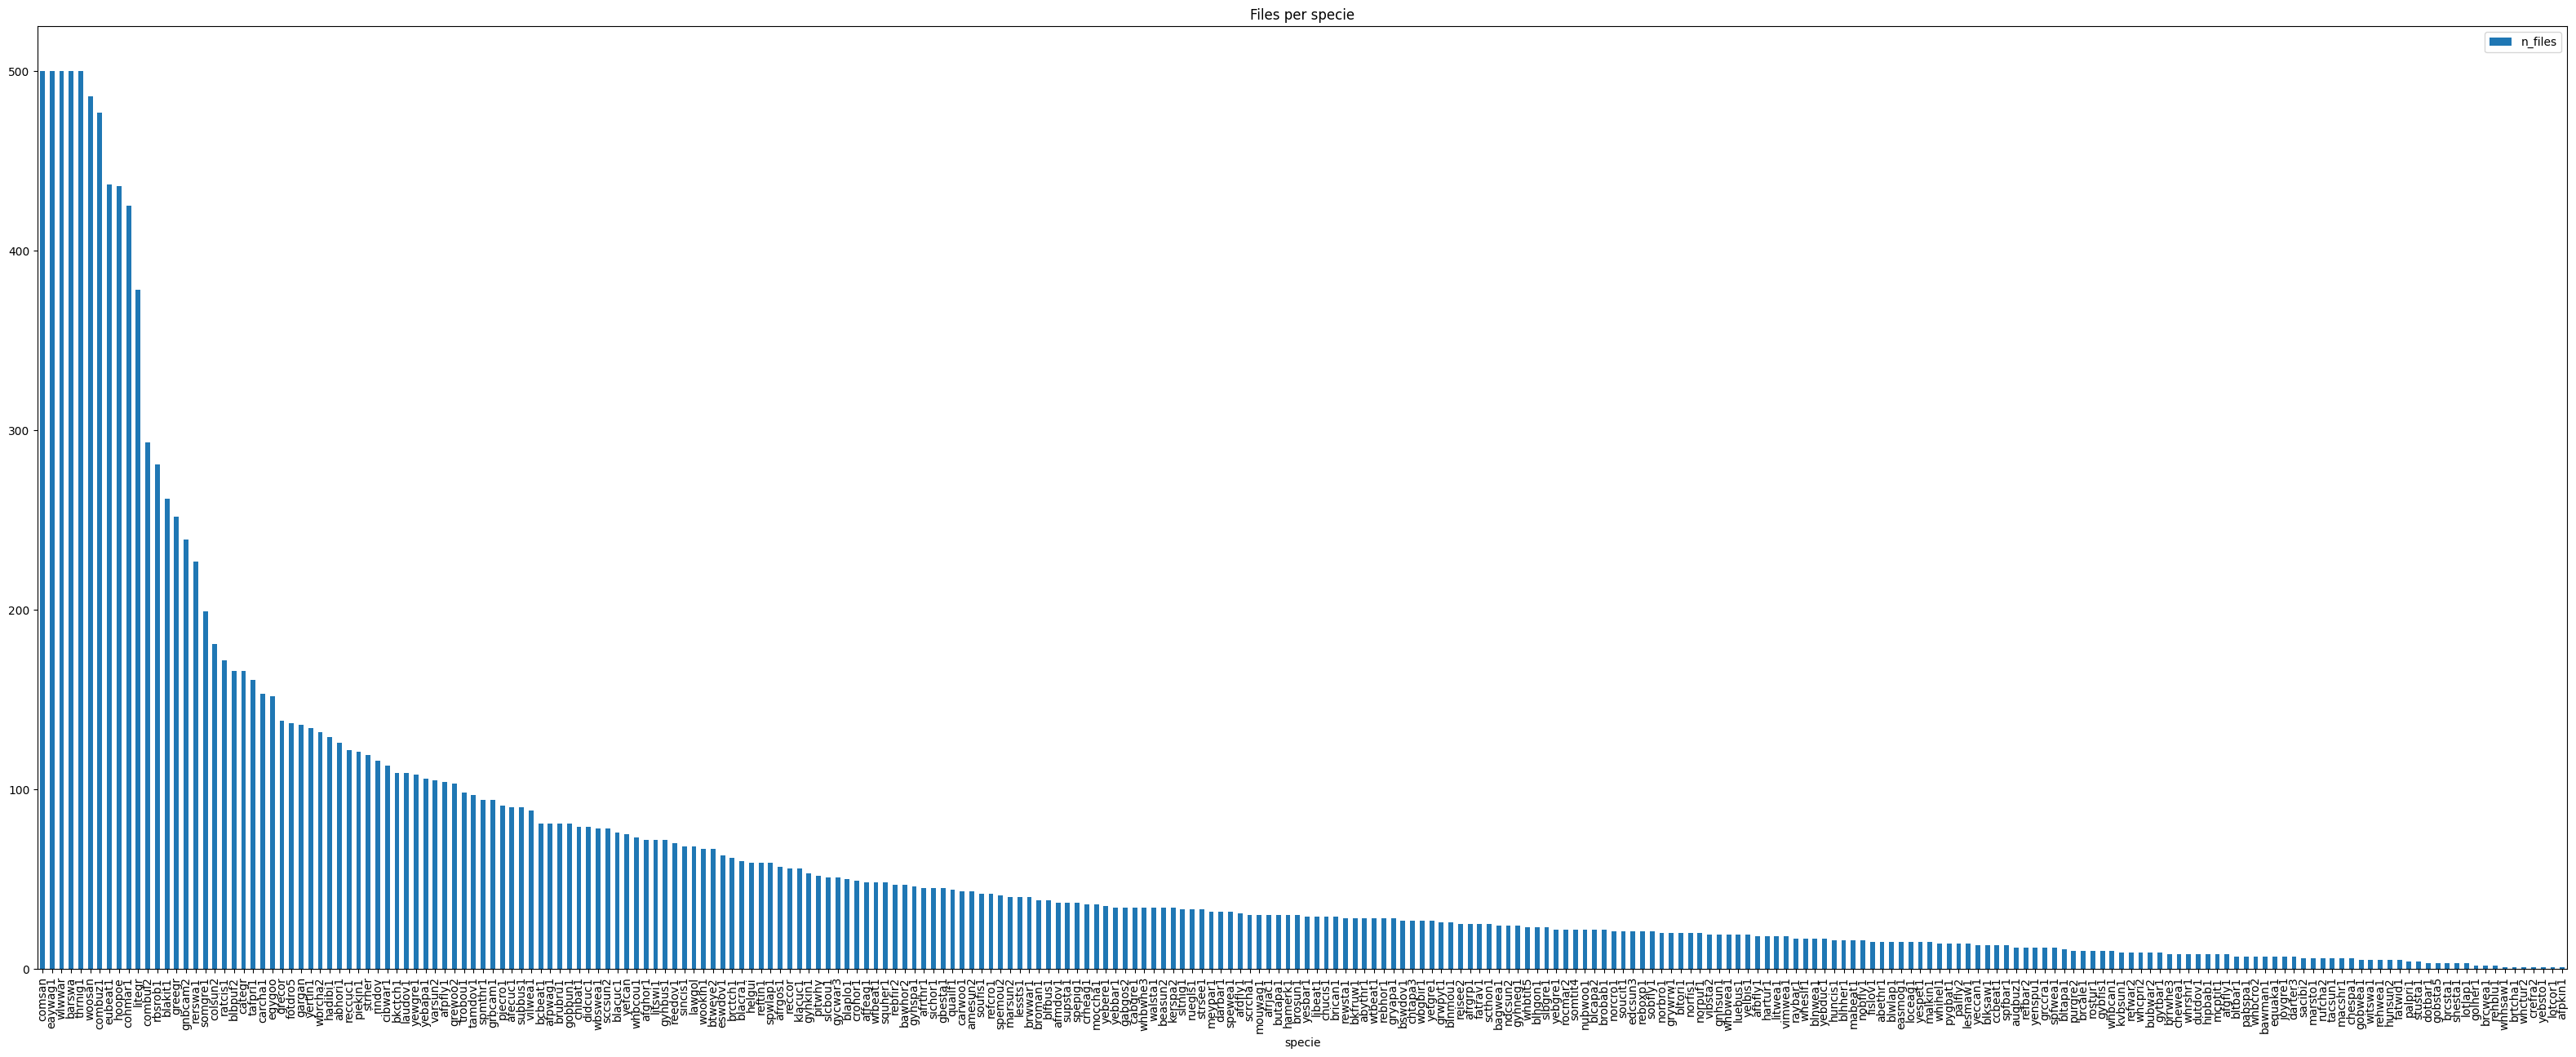

In [ ]:
df = df.sort_values(by='n_files', ascending=False)
df.plot(kind='bar', x = 'specie', y = 'n_files', figsize=(40, 15), title='Files per specie')
plt.show()

## Minutes csv (limit 100)

In [ ]:
def order_dict(dictionary, limit):
    d = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=False)[:limit])
    return d

def csv_minutes_top_100():

  # Nome del file CSV
  nome_file = 'species_per_minutes.csv'

  # Apertura del file in modalità scrittura
  with open(nome_file, 'w', newline='') as file:
      writer = csv.writer(file)

      # Scrittura delle intestazioni
      writer.writerow(['specie', 'minutes'])

      d = order_dict(dictionary, 100)

      # Scrittura del dizionario
      for specie, minutes in d.items():
          writer.writerow([specie, minutes])

In [ ]:
utils =  "/content/drive/MyDrive/Marino_Matrella/utils/"

# Nome del file CSV
nome_file = utils + 'species_per_minutes.csv'

# Dizionario vuoto per i dati
min_top_100 = {}

# Apertura del file in modalità lettura
with open(nome_file, 'r') as file:
    reader = csv.DictReader(file)

    # Scansione delle righe del file CSV
    for riga in reader:
        # Aggiunta della riga al min_top_100
        chiave = riga['specie']  # sostituire 'chiave' con il nome della colonna chiave
        dati = int(float(riga['minutes']))
        min_top_100[chiave] = dati
# print(min_top_100)


mins_100_df = pd.DataFrame.from_dict(min_top_100, orient='index')
mins_100_df.to_csv('min_top_100.csv', index=False)
print(mins_100_df.head)
mins_100_df.describe()

<bound method NDFrame.head of             0
thrnig1  1026
wlwwar    558
eubeat1   514
hoopoe    418
combuz1   414
...       ...
amesun2    25
reccor     25
slcbou1    25
rebfir2    25
marsun2    23

[100 rows x 1 columns]>


0
count   100.000000
mean     99.650000
std     138.748328
min      23.000000
25%      34.750000
50%      52.500000
75%      93.000000
max    1026.000000

{'thrnig1': 1026, 'wlwwar': 558, 'eubeat1': 514, 'hoopoe': 418, 'combuz1': 414, 'cohmar1': 340, 'barswa': 320, 'eaywag1': 279, 'comsan': 258, 'combul2': 240, 'woosan': 224, 'rbsrob1': 192, 'blakit1': 191, 'litegr': 156, 'grecor': 155, 'somgre1': 147, 'gnbcam2': 133, 'rerswa1': 130, 'lawgol': 120, 'colsun2': 120, 'carcha1': 120, 'categr': 117, 'fotdro5': 116, 'wbrcha2': 109, 'abhori1': 93, 'greegr': 93, 'tamdov1': 89, 'ratcis1': 89, 'egygoo': 86, 'yertin1': 78, 'litswi1': 77, 'blbpuf2': 75, 'reccuc1': 71, 'yewgre1': 71, 'tafpri1': 69, 'cibwar1': 69, 'grewoo2': 67, 'laudov1': 66, 'vilwea1': 64, 'hadibi1': 63, 'varsun2': 62, 'bkctch1': 62, 'afpfly1': 60, 'gyhbus1': 60, 'spmthr1': 60, 'grbcam1': 59, 'rindov': 58, 'trobou1': 56, 'afecuc1': 53, 'gobbun1': 53, 'afrthr1': 52, 'gargan': 52, 'chibat1': 51, 'wbswea1': 49, 'piekin1': 46, 'yebapa1': 46, 'afpwag1': 46, 'btweye2': 45, 'blacuc1': 44, 'afrgos1': 43, 'yefcan': 43, 'sccsun2': 42, 'moccha1': 41, 'subbus1': 41, 'piecro1': 40, 'afghor1': 39

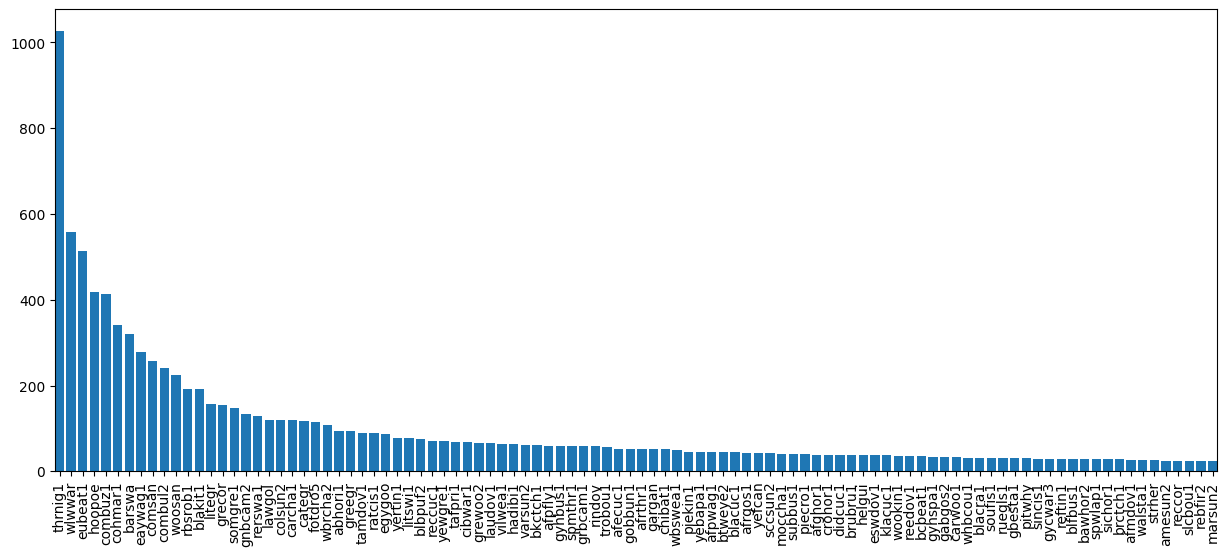

In [ ]:
print(min_top_100, '\n')
plot_graph(min_top_100, 'top_100_minutes')

## Find possible splits

In [ ]:
results = {}

def count_possible_splits():
    print(os.getcwd())
    root = "drive/MyDrive/Marino_Matrella"
    train_audio_dir = os.path.join(root, 'birds', 'train_audio')


    entries = os.listdir(train_audio_dir)
    # print(entries)


    for entry in tqdm(entries): # per ogni specie

        files = os.listdir(os.path.join(train_audio_dir, entry))
        num_files = 0

        for index, file in enumerate(files):  # per ogni audio intero

            audio = AudioSegment.from_file(os.path.join(train_audio_dir, entry, file))
            length_audio = len(audio)

            start = 0
            threshold = 10000
            count = 0
            while start + threshold < len(audio):
                end = start + threshold
                chunk = audio[start:end]
                count += 1
                start += threshold

            num_files += count

        results[entry] = num_files
        # print(f"{entry}: {num_files}")
    import pandas as pd
    df = pd.DataFrame(list(results.items()), columns=['entry', 'num_files'])
    df.to_csv(root + '/utils/results.csv', index=False)

# count_possible_splits()

In [ ]:
df = pd.read_csv(os.path.join(utils,'results.csv'),  index_col=0).squeeze("columns")
results = df.to_dict()

# for k, v in results.items():
#     print(k, v)

first_100 = dict(sorted(results.items(), key=lambda item: item[1], reverse=True)[:100])
print(first_100)
res_k = list(first_100.keys())
top_100 = list(min_top_100.keys())


#to create a list with ids that are in A and found in B (unique)
resultlist=list(set(res_k)&set(top_100))
print(len(resultlist), resultlist)

#to create a list of ids that are in A and have no corresponding in B (unique)
print(list(set(res_k)-set(top_100)))

#the numbers in B, that don't have a corespondent in A
print(list(set(top_100)-set(res_k)))


print(first_100['beasun2'])
print(results['strher'])

{'thrnig1': 5910, 'wlwwar': 3100, 'eubeat1': 2876, 'hoopoe': 2305, 'combuz1': 2243, 'cohmar1': 1827, 'barswa': 1667, 'eaywag1': 1406, 'comsan': 1289, 'combul2': 1287, 'woosan': 1091, 'blakit1': 1027, 'rbsrob1': 1017, 'grecor': 862, 'somgre1': 793, 'litegr': 760, 'lawgol': 694, 'gnbcam2': 679, 'rerswa1': 675, 'carcha1': 648, 'colsun2': 634, 'fotdro5': 634, 'categr': 630, 'wbrcha2': 593, 'abhori1': 499, 'tamdov1': 486, 'ratcis1': 452, 'egygoo': 443, 'litswi1': 433, 'greegr': 431, 'yertin1': 404, 'yewgre1': 375, 'blbpuf2': 372, 'reccuc1': 368, 'cibwar1': 362, 'grewoo2': 353, 'laudov1': 348, 'vilwea1': 344, 'tafpri1': 336, 'gyhbus1': 328, 'varsun2': 328, 'spmthr1': 319, 'bkctch1': 315, 'hadibi1': 313, 'afpfly1': 312, 'grbcam1': 307, 'afrthr1': 296, 'rindov': 293, 'trobou1': 288, 'afecuc1': 282, 'gobbun1': 276, 'chibat1': 266, 'wbswea1': 256, 'gargan': 246, 'btweye2': 243, 'afpwag1': 239, 'afrgos1': 239, 'blacuc1': 232, 'moccha1': 232, 'yebapa1': 224, 'piekin1': 221, 'yefcan': 221, 'sccsun2

{'thrnig1': 5910, 'wlwwar': 3100, 'eubeat1': 2876, 'hoopoe': 2305, 'combuz1': 2243, 'cohmar1': 1827, 'barswa': 1667, 'eaywag1': 1406, 'comsan': 1289, 'combul2': 1287, 'woosan': 1091, 'blakit1': 1027, 'rbsrob1': 1017, 'grecor': 862, 'somgre1': 793, 'litegr': 760, 'lawgol': 694, 'gnbcam2': 679, 'rerswa1': 675, 'carcha1': 648, 'colsun2': 634, 'fotdro5': 634, 'categr': 630, 'wbrcha2': 593, 'abhori1': 499, 'tamdov1': 486, 'ratcis1': 452, 'egygoo': 443, 'litswi1': 433, 'greegr': 431, 'yertin1': 404, 'yewgre1': 375, 'blbpuf2': 372, 'reccuc1': 368, 'cibwar1': 362, 'grewoo2': 353, 'laudov1': 348, 'vilwea1': 344, 'tafpri1': 336, 'gyhbus1': 328, 'varsun2': 328, 'spmthr1': 319, 'bkctch1': 315, 'hadibi1': 313, 'afpfly1': 312, 'grbcam1': 307, 'afrthr1': 296, 'rindov': 293, 'trobou1': 288, 'afecuc1': 282, 'gobbun1': 276, 'chibat1': 266, 'wbswea1': 256, 'gargan': 246, 'btweye2': 243, 'afpwag1': 239, 'afrgos1': 239, 'blacuc1': 232, 'moccha1': 232, 'yebapa1': 224, 'piekin1': 221, 'yefcan': 221, 'sccsun2

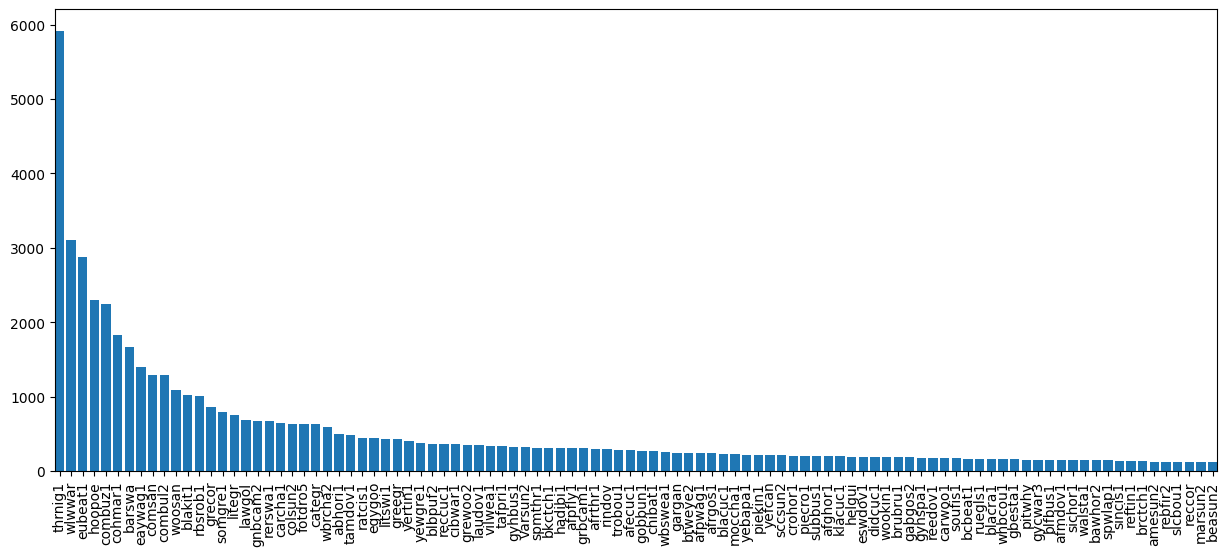

In [ ]:
print(first_100, '\n')
plot_graph(first_100, 'top_100_splittable')

## Audio frequency

In [ ]:
dictionary = {}

entries = os.listdir('birds/converted')

print(entries)
for entry in entries: #for each specie (one folder for each one)
    files = os.listdir('birds/converted/' + entry)

    #get all the audio for each specie
    for file in files:
        print(file)
        Fs, data = read('birds/converted/' + entry + '/' + file)
        print(data)
        #data = data[:,0]
        print("Sampling Frequency is", Fs)

## Play cleaned audio

In [ ]:
Audio(data, rate=Fs)

In [ ]:
y, sr = librosa.load('birds/converted/abhori1/XC756300.wav')
reduced_noise = nr.reduce_noise(y=y, sr=sr, stationary=True)
IPython.display.Audio(data=y, rate=sr)

In [ ]:
# load data
rate, data = wavfile.read("birds/converted/abhori1/XC247351.wav")
# perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("birds/XC247351.wav", rate, reduced_noise)

## Plot the wave

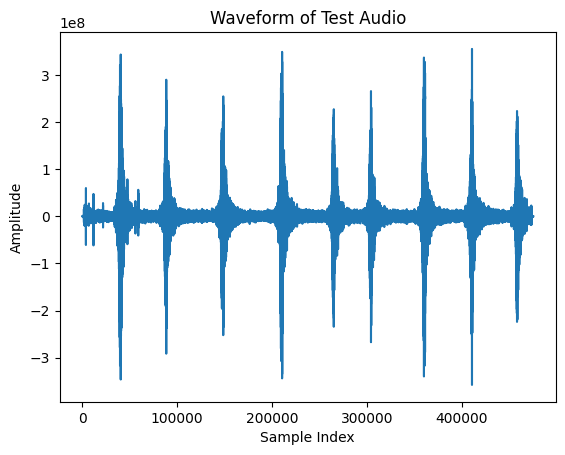

In [ ]:
plt.figure()
plt.plot(data)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio')
plt.show()

# Split audio in segments

In [ ]:
def split_audio():
    print(os.getcwd())
    root = "drive/MyDrive/Marino_Matrella"
    train_audio_dir = os.path.join(root, 'birds', 'train_audio')
    split_audio_dir = os.path.join(root, 'birds', 'splitaudio')

    entries = os.listdir(train_audio_dir)
    for entry in entries:
        destination_dir = os.path.join(split_audio_dir, entry)
        os.makedirs(destination_dir, exist_ok=True)
        print(os.listdir(split_audio_dir))
        files = os.listdir(os.path.join(train_audio_dir, entry))

        for index, file in enumerate(files):

            audio = AudioSegment.from_file(os.path.join(train_audio_dir, entry, file))
            length_audio = len(audio)
            # print("Length of Audio File:", length_audio)

            start = 0
            threshold = 10000
            count = 0
            while start + threshold < len(audio):
                end = start + threshold
                chunk = audio[start:end]
                name = file.split(".")
                filename = f"{name[0]}_{count}.ogg"
                chunk.export(os.path.join(destination_dir, filename), format="ogg")
                count += 1
                start += threshold
split_audio()

In [ ]:
def split_audio():
    root = "drive/MyDrive/CIDL project"
    train_audio_dir = os.path.join(root, 'birds', 'train_audio')
    split_audio_dir = os.path.join(root, 'birds', 'splitaudio')

    entries = os.listdir(train_audio_dir)
    for entry in entries:
        destination_dir = os.path.join(split_audio_dir, entry)
        os.makedirs(destination_dir, exist_ok=True)
        files = os.listdir(os.path.join(train_audio_dir, entry))

        for index, file in enumerate(files):

            audio = AudioSegment.from_file(os.path.join(train_audio_dir, entry, file))
            length_audio = len(audio)
            # print("Length of Audio File:", length_audio)

            start = 0
            threshold = 10000
            count = 0
            while start + threshold < len(audio):
                end = start + threshold
                chunk = audio[start:end]
                name = file.split(".")
                filename = f"{name[0]}_{count}.ogg"
                chunk.export(os.path.join(destination_dir, filename), format="ogg")
                count += 1
                start += threshold

In [ ]:
import os
split_audio()

##Check splitted

In [ ]:
def count_splitted():
    print(os.getcwd())
    root = "drive/MyDrive/CIDL project"
    train_audio_dir = os.path.join(root, 'birds', 'train_audio')
    split_audio_dir = os.path.join(root, 'birds', 'splitaudio')

    entries = list(first_100.keys())  # specie folders list
    print(entries)


    for entry in tqdm(entries): # per ogni specie
        # print('\n',entry)
        destination_dir = os.path.join(split_audio_dir, entry)
        num_exits = len(os.listdir(destination_dir))

        files = os.listdir(os.path.join(train_audio_dir, entry))
        num_files = 0

        for index, file in enumerate(files):  # per ogni audio intero

            audio = AudioSegment.from_file(os.path.join(train_audio_dir, entry, file))
            length_audio = len(audio)

            start = 0
            threshold = 10000
            count = 0
            while start + threshold < len(audio):
                end = start + threshold
                chunk = audio[start:end]
                count += 1
                start += threshold

            num_files += count


        assert num_files == num_exits, f"{entry}: splitted should be {num_files} but {num_exits} found"

count_splitted()

/content
['thrnig1', 'wlwwar', 'eubeat1', 'hoopoe', 'combuz1', 'cohmar1', 'barswa', 'eaywag1', 'comsan', 'combul2', 'woosan', 'blakit1', 'rbsrob1', 'grecor', 'somgre1', 'litegr', 'lawgol', 'gnbcam2', 'rerswa1', 'carcha1', 'colsun2', 'fotdro5', 'categr', 'wbrcha2', 'abhori1', 'tamdov1', 'ratcis1', 'egygoo', 'litswi1', 'greegr', 'yertin1', 'yewgre1', 'blbpuf2', 'reccuc1', 'cibwar1', 'grewoo2', 'laudov1', 'vilwea1', 'tafpri1', 'gyhbus1', 'varsun2', 'spmthr1', 'bkctch1', 'hadibi1', 'afpfly1', 'grbcam1', 'afrthr1', 'rindov', 'trobou1', 'afecuc1', 'gobbun1', 'chibat1', 'wbswea1', 'gargan', 'btweye2', 'afpwag1', 'afrgos1', 'blacuc1', 'moccha1', 'yebapa1', 'piekin1', 'yefcan', 'sccsun2', 'crohor1', 'piecro1', 'subbus1', 'afghor1', 'klacuc1', 'helgui', 'eswdov1', 'didcuc1', 'wookin1', 'brubru1', 'gabgos2', 'gyhspa1', 'reedov1', 'carwoo1', 'soufis1', 'bcbeat1', 'ruegls1', 'blacra1', 'whbcou1', 'gbesta1', 'pitwhy', 'gycwar3', 'blfbus1', 'afmdov1', 'sichor1', 'walsta1', 'bawhor2', 'spwlap1', 'sinc

  0%|          | 0/100 [00:00<?, ?it/s]

# Generate spectrograms

In [ ]:
root = "drive/MyDrive/Marino_Matrella"
def generate_spectr():
    species = os.listdir(os.path.join(root, 'birds', 'splitaudio'))
    species.remove(".ipynb_checkpoints")
    print("Number of species: ", len(species))
    print(species, '\n')

    for specie in tqdm(species):
        print("Specie", specie)
        if not os.path.exists(os.path.join(root,'birds','spectrograms',specie)):
            print("Creating dir...")
            os.makedirs(os.path.join(root,'birds','spectrograms',specie))

        specie_folder = os.path.join(root, 'birds', 'splitaudio', specie)
        audios = os.listdir(specie_folder)

        for audio in tqdm(audios):
            audio_path = os.path.join(specie_folder, audio)
            if not os.path.isfile(audio_path) or audio_path in os.listdir(os.path.join(root,'birds','spectrograms',specie)):
                continue  # Salta se non è un file

            y, sr = librosa.load(audio_path)
            y = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2, stationary=False) # reduce noise

            # Compute mel spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=224)
            S = librosa.power_to_db(S, ref=np.max)

            # Resize spectrogram to 224x224
            img = Image.fromarray(S)
            img = img.resize((224, 224), resample=Image.BILINEAR)
            S = np.array(img)
            plt.figure()
            librosa.display.specshow(S,
                                    y_axis='mel', x_axis='time',
                                    sr=sr, cmap='gray_r', fmax=8000)
            plt.axis('off')

            # Save spectrogram to file
            filename = os.path.splitext(audio)[0] + '.png'
            save_path = os.path.join(root, 'birds', 'spectrograms', specie, filename)
            plt.savefig(save_path, bbox_inches='tight')

            plt.close()  # Close the figure to free memory

generate_spectr()

Number of species:  102
['afecuc1', 'afghor1', 'abhori1', 'afpfly1', 'afmdov1', 'afpwag1', 'afrgos1', 'afrthr1', 'amesun2', 'bkctch1', 'barswa', 'blacra1', 'bawhor2', 'bcbeat1', 'blacuc1', 'blakit1', 'blbpuf2', 'brctch1', 'brubru1', 'carcha1', 'carwoo1', 'btweye2', 'categr', 'combuz1', 'combul2', 'comsan', 'chibat1', 'colsun2', 'cohmar1', 'cibwar1', 'eaywag1', 'crohor1', 'didcuc1', 'egygoo', 'eswdov1', 'fotdro5', 'gnbcam2', 'gabgos2', 'eubeat1', 'gbesta1', 'gargan', 'gobbun1', 'grewoo2', 'greegr', 'grbcam1', 'grecor', 'gycwar3', 'gyhbus1', 'helgui', 'gyhspa1', 'hadibi1', 'hoopoe', 'lawgol', 'klacuc1', 'laudov1', 'litegr', 'litswi1', 'marsun2', 'moccha1', 'piecro1', 'piekin1', 'ratcis1', 'pitwhy', 'rbsrob1', 'rebfir2', 'reccor', 'reccuc1', 'reedov1', 'rerswa1', 'reftin1', 'rindov', 'sccsun2', 'ruegls1', 'sichor1', 'sincis1', 'soufis1', 'somgre1', 'slcbou1', 'spwlap1', 'spmthr1', 'subbus1', 'tafpri1', 'walsta1', 'varsun2', 'tamdov1', 'vilwea1', 'wbrcha2', 'wbswea1', 'whbcou1', 'yebapa1',

  0%|          | 0/102 [00:00<?, ?it/s]

Specie afecuc1
Specie afghor1
Specie abhori1
Specie afpfly1
Specie afmdov1
Specie afpwag1
Specie afrgos1
Specie afrthr1
Specie amesun2
Specie bkctch1
Specie barswa
Specie blacra1
Specie bawhor2
Specie bcbeat1
Specie blacuc1
Specie blakit1
Specie blbpuf2
Specie brctch1
Specie brubru1
Specie carcha1
Specie carwoo1
Specie btweye2
Specie categr
Specie combuz1
Specie combul2
Specie comsan
Specie chibat1
Specie colsun2
Specie cohmar1
Specie cibwar1
Specie eaywag1
Specie crohor1
Specie didcuc1
Specie egygoo
Specie eswdov1
Specie fotdro5
Specie gnbcam2
Specie gabgos2
Specie eubeat1
Specie gbesta1
Specie gargan
Specie gobbun1
Specie grewoo2
Specie greegr
Specie grbcam1
Specie grecor
Specie gycwar3
Specie gyhbus1
Specie helgui
Specie gyhspa1
Specie hadibi1
Specie hoopoe
Specie lawgol
Specie klacuc1
Specie laudov1
Specie litegr
Specie litswi1
Specie marsun2
Specie moccha1
Specie piecro1
Specie piekin1
Specie ratcis1
Specie pitwhy
Specie rbsrob1
Specie rebfir2
Specie reccor
Specie reccuc1
Specie r


100%|██████████| 102/102 [00:59<00:00,  1.70it/s]


## Check dataset

In [ ]:
#check dataset files

import pandas as pd
import os

audio_path = '/content/drive/MyDrive/CIDL project/birds/splitaudio'
spectr_path = '/content/drive/MyDrive/CIDL project/birds/spectrograms'

num_audio = {}
num_spectr = {}

for dir in os.listdir(audio_path):
  num_audio[dir] = len(os.listdir(os.path.join(audio_path,dir)))

for dir in os.listdir(spectr_path):
  num_spectr[dir] = len(os.listdir(os.path.join(spectr_path,dir)))
  assert num_audio[dir] == num_spectr[dir], f"{dir}: splitaudio has {num_audio[dir]} but spectrograms has {num_spectr[dir]}"


.ipynb_checkpoints :  0 0
afghor1 :  201 201
abhori1 :  499 499
afpfly1 :  312 312
afmdov1 :  150 150
afpwag1 :  239 239
afrgos1 :  239 239
afrthr1 :  296 296
amesun2 :  131 131
bkctch1 :  315 315
barswa :  1667 1667
blacra1 :  164 164
bawhor2 :  147 147
bcbeat1 :  170 170
blacuc1 :  232 232
blakit1 :  1027 1027
blfbus1 :  152 152
blbpuf2 :  372 372
brctch1 :  134 134
brubru1 :  186 186
carcha1 :  648 648
carwoo1 :  177 177
btweye2 :  243 243
categr :  630 630
combuz1 :  2243 2243
combul2 :  1287 1287
comsan :  1289 1289
chibat1 :  266 266
colsun2 :  634 634
cohmar1 :  1827 1827
cibwar1 :  362 362
eaywag1 :  1406 1406
crohor1 :  207 207
didcuc1 :  192 192
egygoo :  443 443
eswdov1 :  193 193
fotdro5 :  634 634
gnbcam2 :  679 679
gabgos2 :  186 186
eubeat1 :  2876 2876
gbesta1 :  159 159
gargan :  246 246
gobbun1 :  276 276
grewoo2 :  353 353
greegr :  431 431
grbcam1 :  307 307
grecor :  862 862
gycwar3 :  153 153
gyhbus1 :  328 328
helgui :  197 197
gyhspa1 :  185 185
hadibi1 :  313 3

In [ ]:
audio_path_thrnig1 = '/content/drive/MyDrive/CIDL project/birds/splitaudio/thrnig1'
spectr_path_thrnig1 = '/content/drive/MyDrive/CIDL project/birds/spectrograms/thrnig1'

audio_list_thrnig1 = os.listdir(audio_path_thrnig1)
spectr_list_thrnig1 = os.listdir(spectr_path_thrnig1)
dup = list(set(audio_list_thrnig1).intersection(spectr_list_thrnig1))
print(dup)
diff = [x for x in spectr_list_thrnig1 if x.split('.')[0]+'.ogg' not in audio_list_thrnig1]
print(len(diff),diff)
# for image in dup:
#     myfile = os.path.join(spectr_path, image)
#     if os.path.isfile(myfile):
#         os.remove(myfile)

[]
0 []


## Rename directories with common names

In [ ]:
def getCommonNames():

    dictionary = {}

    # root = os.getcwd()

    with open(os.path.join(root, 'birds', 'train_metadata.csv'), mode='r', encoding="utf8") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
    #             print(f'\t{row[0]} to change into {row[6]}.')
                if row[0] not in dictionary:
                    dictionary[row[0]] = row[6]
    #             else:
    #                 print(f'Duplicate key found: {row[0]}. Skipping...')
                line_count += 1
        print(f'Processed {line_count} lines.')

    unique_dictionary = {k: v for k, v in dictionary.items()}  # Rimuove i duplicati dal dizionario
    # for k, v in unique_dictionary.items():
    #     print(k, " : ", v)
    return unique_dictionary

In [ ]:
import os
import csv
import shutil
root = "drive/MyDrive/CIDL project"
names = getCommonNames()
#thrnig1, trobou1, strher

arrival_path = "drive/MyDrive/CIDL project/birds/spectrograms"
val = names.values()
key = list(names.keys())
for dir in os.listdir(arrival_path):
  if dir in val:
    for file_name in os.listdir(arrival_path +"/"+ dir):
      value = list(val)
      index = value.index(dir)
      origin = arrival_path + "/" + dir+"/"+file_name
      target = arrival_path+"/"+ key[index] +"/"+file_name
      print(target, str(os.path.exists(target)))
      if os.path.exists(target) != True:
        shutil.copy(arrival_path + "/" + dir+"/"+file_name, arrival_path+"/"+ key[index] +"/"+file_name)

In [ ]:
getCommonNames()

Column names are primary_label, secondary_labels, type, latitude, longitude, scientific_name, common_name, author, license, rating, url, filename
Processed 16942 lines.


{'abethr1': 'African Bare-eyed Thrush',
 'abhori1': 'African Black-headed Oriole',
 'abythr1': 'Abyssinian Thrush',
 'afbfly1': 'African Blue Flycatcher',
 'afdfly1': 'African Dusky Flycatcher',
 'afecuc1': 'African Emerald Cuckoo',
 'affeag1': 'African Fish-Eagle',
 'afgfly1': 'African Gray Flycatcher',
 'afghor1': 'African Gray Hornbill',
 'afmdov1': 'Mourning Collared-Dove',
 'afpfly1': 'African Paradise-Flycatcher',
 'afpkin1': 'African Pygmy Kingfisher',
 'afpwag1': 'African Pied Wagtail',
 'afrgos1': 'African Goshawk',
 'afrgrp1': 'African Green-Pigeon',
 'afrjac1': 'African Jacana',
 'afrthr1': 'African Thrush',
 'amesun2': 'Amethyst Sunbird',
 'augbuz1': 'Augur Buzzard',
 'bagwea1': 'Baglafecht Weaver',
 'barswa': 'Barn Swallow',
 'bawhor2': 'Black-and-white-casqued Hornbill',
 'bawman1': 'Black-and-white Mannikin',
 'bcbeat1': 'Blue-cheeked Bee-eater',
 'beasun2': 'Beautiful Sunbird',
 'bkctch1': 'Black-crowned Tchagra',
 'bkfruw1': 'Black-faced Rufous-Warbler',
 'blacra1': 'B

In [ ]:
folder_path = os.path.join(root, 'birds', 'spectrograms')

for folder_name in os.listdir(folder_path):
    folder_old_path = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder_old_path):
        if folder_name in dictionary:
            folder_new_name = dictionary[folder_name]
            folder_new_path = os.path.join(folder_path, folder_new_name)
            os.rename(folder_old_path, folder_new_path)
            print(f'Renamed folder: {folder_name} -> {folder_new_name}')
        else:
            print(f'No corresponding value found for folder: {folder_name}. Skipping...')

Column names are primary_label, secondary_labels, type, latitude, longitude, scientific_name, common_name, author, license, rating, url, filename
Processed 16942 lines.
abethr1  :  African Bare-eyed Thrush
abhori1  :  African Black-headed Oriole
abythr1  :  Abyssinian Thrush
afbfly1  :  African Blue Flycatcher
afdfly1  :  African Dusky Flycatcher
afecuc1  :  African Emerald Cuckoo
affeag1  :  African Fish-Eagle
afgfly1  :  African Gray Flycatcher
afghor1  :  African Gray Hornbill
afmdov1  :  Mourning Collared-Dove
afpfly1  :  African Paradise-Flycatcher
afpkin1  :  African Pygmy Kingfisher
afpwag1  :  African Pied Wagtail
afrgos1  :  African Goshawk
afrgrp1  :  African Green-Pigeon
afrjac1  :  African Jacana
afrthr1  :  African Thrush
amesun2  :  Amethyst Sunbird
augbuz1  :  Augur Buzzard
bagwea1  :  Baglafecht Weaver
barswa  :  Barn Swallow
bawhor2  :  Black-and-white-casqued Hornbill
bawman1  :  Black-and-white Mannikin
bcbeat1  :  Blue-cheeked Bee-eater
beasun2  :  Beautiful Sunbird

# Split into test, training, validation

In [ ]:
# Percorso del dataset radice
root_path = os.path.join(root,'birds/spectrograms')

# Cartella di destinazione per i set di addestramento, test e validation
#output_path = 'drive/MyDrive/CIDL project/birds/dataset'
output_path = os.path.join(root,'birds/full_dataset')

train_percent = 0.75
test_percent = 0.10
validation_percent = 0.15

# Lista di tutte le immagini nel dataset
all_images = []

# Lista delle etichette di classe
all_labels = []

# Scorrere le cartelle e le immagini
for folder_name in os.listdir(root_path):
    folder_path = os.path.join(root_path, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
          image_path = os.path.join(folder_path, image_name)
          all_images.append(image_path)
          all_labels.append(folder_name)

# Suddivisione del dataset
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=test_percent, random_state=42, shuffle=True, stratify=all_labels)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=validation_percent/(1.0-test_percent), random_state=42, shuffle=True, stratify=train_val_labels)

# Funzione per copiare le immagini in una cartella di destinazione
def copy_images(images, class_name, output_folder):
    for i in tqdm(range(len(images))):
        image_path = images[i]
        class_folder = os.path.join(output_folder, class_name[i])
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(image_path, class_folder)

# Copia le immagini
copy_images(train_images, train_labels, os.path.join(output_path, "train"))
copy_images(test_images, test_labels, os.path.join(output_path, "test"))
copy_images(val_images, val_labels, os.path.join(output_path, "validation"))


100%|██████████| 7982/7982 [35:18<00:00,  3.77it/s]


#Data Augmentation

## Count samples training set per specie

In [ ]:
#apply upsample to training set

import pandas as pd
import os

output_path = '/content/drive/MyDrive/Marino_Matrella/birds/dataset/train'

# Lista di tutte le immagini nel dataset
all_images = []

# Lista delle etichette di classe
all_labels = []

#Scorro train_set
for dir in os.listdir(output_path):
  for img in os.listdir(os.path.join(output_path,dir)):
    all_images.append(os.path.join(output_path,dir, img))
    all_labels.append(dir)

train_df = pd.DataFrame(all_labels, columns=['primary_label'])
train_df['file'] = all_images

print(train_df.head())
# pd.set_option('max_colwidth', 400)


  primary_label                                               file
0       marsun2  /content/drive/MyDrive/CIDL project/birds/data...
1       marsun2  /content/drive/MyDrive/CIDL project/birds/data...
2       marsun2  /content/drive/MyDrive/CIDL project/birds/data...
3       marsun2  /content/drive/MyDrive/CIDL project/birds/data...
4       marsun2  /content/drive/MyDrive/CIDL project/birds/data...


In [ ]:
class_dist = train_df['primary_label'].value_counts()
# identify the classes that have less than the threshold number of samples
down_classes = class_dist[class_dist < 100].index.tolist()
down_classes

['slcbou1', 'rebfir2', 'amesun2', 'reccor', 'marsun2', 'beasun2']

## SpecAugment

In [ ]:
print(os.getcwd())
input_path = "birds/dataset/augment"
aug_ds = image_dataset_from_directory(
    input_path,
    image_size=(224, 224),
    labels="inferred",
    batch_size=32)
spec_augment = keras.Sequential([

#  LB usato
  SpecAugment(freq_mask_param=27,
                           time_mask_param=100,
                           n_freq_mask=1,
                           n_time_mask=1,
                           mask_value=-100)
  #LD
    # SpecAugment(freq_mask_param=27,
    #                        time_mask_param=100,
    #                        n_freq_mask=2,
    #                        n_time_mask=2,
    #                        mask_value=-100)
  #SM usato
  # SpecAugment(freq_mask_param=15,
  #                          time_mask_param=70,
  #                          n_freq_mask=2,
  #                          n_time_mask=2,
  #                          mask_value=-100)
  #SS
  #  SpecAugment(freq_mask_param=27,
  #                          time_mask_param=70,
  #                          n_freq_mask=2,
  #                          n_time_mask=2,
  #                          mask_value=-100)
])

aug = aug_ds.map(
  lambda x, y: (spec_augment(x, training=True), y))

/content/drive/.shortcut-targets-by-id/1pfBa0fnatsy0qYLtZ2wpGwzSR-zOPP2W/CIDL project
Found 637 files belonging to 8 classes.


In [ ]:
destination_folder = "birds/dataset/out_augment/"
class_names = aug_ds.class_names

#Save augmented images
for j, (image, label) in enumerate(aug):
  label_array = label.numpy()
  for i in range(len(label_array)):

    class_index = str(label_array[i])

    class_folder = os.path.join(destination_folder, class_names[int(class_index)])
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    image_path = os.path.join(destination_folder, class_names[int(class_index)], f"image_{i+32}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, image[i])


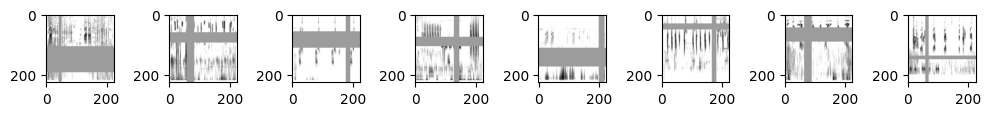

In [ ]:
fig, axs = plt.subplots(1, 8, figsize=(10, 10))
for images, _ in aug.take(1):
  for i in range(8):
    original = images[i].numpy().astype(np.uint8)
    axs[i].imshow(original)
fig.tight_layout()
plt.show()

## Spectrogram Augmentation

In [ ]:
%run '/content/drive/MyDrive/Marino_Matrella/ImageProcessing.ipynb'

In [ ]:
import os, os.path
import cv2
import numpy as np
import copy

DATASET_PATH = os.path.join(root, 'birds/dataset/train')
DATASET_NOISE_PATH = os.path.join(root, 'birds/dataset/aug_spec')
min_spec_num = 100

def count_spec_num(path):
    spec_num = []
    index = 0
    for specie in down_classes:
        spec_data = os.path.join(path, specie)
        spec_num.append(len([name for name in os.listdir(spec_data) if os.path.isfile(os.path.join(spec_data, name))]))
        if spec_num[index] < min_spec_num:
            print(specie)
        index += 1
    print()
    return spec_num



RANDOM_SEED = 1337
RANDOM = np.random.RandomState(RANDOM_SEED)


# Image augmentation, uncomment to use; specify mode + value
IM_AUGMENTATION = {'roll_h':0.5,                   # Horizontal roll
                   #'roll_v':0.15,                   # Vertical roll
                   #'crop':[0.1, 0.0, 0.05, 0.0],   # Random crop - top, left, bottom, right
                   'noise':0.05,                   # Gaussian noise
                   #'add':NOISE_SAMPLES,             # List of specs to add to original sample
                   'brightness':0.15,              # Adjust brightness
                   #'dropout':0.25,                 # Dropout single pixels
                   #'blackout':0.10,                # Dropout entire regions
                   'blur':3,                       # Image blur
                   #'zoom':0.25,                    # Random zoom (equally cropping each side)
                   #'rotate':10,                    # Rotate by angle
                   #'multiply':0.25,                # Multiply pixel values
                   #'mean':True                     # Substract mean from image
                  }

# Maximum number of random augmentations per image
# Each try has 50% chance of success; we do not use duplicate augmentations
AUGMENTATION_COUNT = 2

# Probability for image augmentation
#AUGMENTATION_PROBABILITY = 0.5 #origin
AUGMENTATION_PROBABILITY = 1

def call_augmentation(spec_num,path):
    i = 0
    print("--------------AUGMENTATION--------------")
    for specie in down_classes:
        print("Specie: ", specie, '\n')
        spec_path = os.path.join(path, specie)
        # print(spec_path)
        spec_noise_path = os.path.join(DATASET_NOISE_PATH, specie)  #augmented files dir
        # print(spec_noise_path)
        if not os.path.exists(spec_noise_path):
          os.makedirs(spec_noise_path)

        c = 0
        for file in os.listdir(spec_path):
            print('FILE: ',file)
            img = openImage(os.path.join(spec_path,file))
            if c == 0 or c == 30:
                print('PRIMA: ')
                plt.imshow(img)
                plt.show()
            img = augment(img, IM_AUGMENTATION, AUGMENTATION_COUNT, AUGMENTATION_PROBABILITY)
            if c == 0 or c == 30:
                print('DOPO: ')
                plt.imshow(img)
                plt.show()
            img_aug_path = spec_path + '/' + str(c) + file #origin
            img_aug_path = spec_noise_path + '/augmented-' + file
            cv2.imwrite(img_aug_path, 255*img)
            c += 1

        i += 1
        #print(i)
        print()

spec_num = count_spec_num(DATASET_PATH)
print(f"# original train classes: {len(spec_num)}")
print(f"min: {min(spec_num)}")
# call_augmentation(spec_num, DATASET_PATH)
spec_num = count_spec_num(DATASET_NOISE_PATH)
print(f"# augmented train classes: {len(spec_num)}")
print(f"min: {min(spec_num)}")

slcbou1
rebfir2
amesun2
reccor
marsun2
beasun2

# original train classes: 6
min: 90
slcbou1
rebfir2
amesun2
reccor
marsun2
beasun2

# augmented train classes: 6
min: 90


In [ ]:
names = []
d = {}
for specie in down_classes:
    print(specie)
    spec_path = os.path.join(DATASET_PATH, specie)
    # print(spec_path)
    for ogg in os.listdir(spec_path):
        # print(ogg)
        name = (ogg.split('.')[0])
        d[name] = 0
    # print(d)

print()

for specie in down_classes:
    print(specie)
    spec_path = os.path.join(DATASET_PATH, specie)
    #print(spec_path)
    spec_noise_path = os.path.join(DATASET_NOISE_PATH, specie)
    #print(spec_noise_path)
    for ogg in os.listdir(spec_noise_path):
        name = ogg.split('-')[1].split('.')[0]
        # print(name)
        d[name] = d.get(name, 0) + 1
    #print(d)

slcbou1
rebfir2
amesun2
reccor
marsun2
beasun2

slcbou1
rebfir2
amesun2
reccor
marsun2
beasun2


In [ ]:
from distutils.dir_util import copy_tree
import random

DATASET_PATH = os.path.join(root, 'birds/dataset/train')
DATASET_NOISE_PATH = os.path.join(root, 'birds/dataset/aug_spec')
DATASET_AUGMENTED = os.path.join(root, 'birds/dataset/train_aug_spec')
min_spec_num = 100


copy_tree(DATASET_PATH, DATASET_AUGMENTED)

In [ ]:
print(len(os.listdir(DATASET_PATH)))
print(len(os.listdir(DATASET_NOISE_PATH)))
print(len(os.listdir(DATASET_AUGMENTED)))

for specie in down_classes:
  augmented_specie = os.listdir(os.path.join(DATASET_AUGMENTED,specie))
  noise_specie = os.listdir(os.path.join(DATASET_NOISE_PATH,specie))
  print(specie, len(augmented_specie), len(noise_specie))

100
6
100
slcbou1 100 97
rebfir2 100 95
amesun2 100 95
reccor 100 92
marsun2 100 90
beasun2 100 90


In [ ]:
for specie in down_classes:
  augmented_specie = os.listdir(os.path.join(DATASET_AUGMENTED,specie))
  noise_specie = os.listdir(os.path.join(DATASET_NOISE_PATH,specie))
  print(specie, len(augmented_specie), len(noise_specie))
  i=0
  while len(augmented_specie)+i < 100:
    r = noise_specie.pop(random.randrange(len(noise_specie)))
    print(r)
    source = os.path.join(DATASET_NOISE_PATH,specie,r)
    dest = os.path.join(DATASET_AUGMENTED,specie,r)
    # print(source, dest)
    shutil.copyfile(source, dest)
    i=i+1
  print("After copy: ", len(os.listdir(os.path.join(DATASET_AUGMENTED,specie))),'\n')


slcbou1 97 97
augmented-XC432643_1.png
augmented-XC440823_0.png
augmented-XC432643_0.png
After copy:  100 

rebfir2 95 95
augmented-XC714590_1.png
augmented-XC447490_2.png
augmented-XC421995_5.png
augmented-XC714589_1.png
augmented-XC709144_0.png
After copy:  100 

amesun2 95 95
augmented-XC444804_2.png
augmented-XC652187_6.png
augmented-XC398317_0.png
augmented-XC438652_2.png
augmented-XC438652_6.png
After copy:  100 

reccor 92 92
augmented-XC312724_1.png
augmented-XC345999_1.png
augmented-XC513848_0.png
augmented-XC246658_1.png
augmented-XC405791_10.png
augmented-XC294650_4.png
augmented-XC376080_3.png
augmented-XC405791_4.png
After copy:  100 

marsun2 90 90
augmented-XC600167_0.png
augmented-XC344113_1.png
augmented-XC728969_3.png
augmented-XC307293_2.png
augmented-XC381144_0.png
augmented-XC477686_0.png
augmented-XC307293_1.png
augmented-XC153874_4.png
augmented-XC650517_0.png
augmented-XC397193_2.png
After copy:  100 

beasun2 90 90
augmented-XC722834_8.png
augmented-XC357241_0.

# Upsampling and downsampling


In [ ]:
import random
from tensorflow import keras as ks

import tensorflow as tf

down_class = {}
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()
    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()
    # create an empty list to store the upsampled dataframes
    up_dfs = []
    print(up_dfs)
    # # loop through the undersampled classes and upsample them

    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        down_class[c] = num_up
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=3)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)

    return up_df

def downsample_data(df, thr=500):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    up_classes = class_dist[class_dist > thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    down_dfs = []

    # loop through the undersampled classes and upsample them
    for c in up_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # Remove that class data
        df = df.query("primary_label!=@c")
        # upsample the dataframe
        class_df = class_df.sample(n=thr, replace=False, random_state=3)
        # append the upsampled dataframe to the list
        down_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    down_df = pd.concat([df] + down_dfs, axis=0, ignore_index=True)

    return down_df

[]
{'amesun2': 2, 'rebfir2': 3, 'slcbou1': 4, 'reccor': 5, 'marsun2': 9, 'beasun2': 10}
# Pretraing Dataset
> Original: 39910
> After Upsample: 39943
> After Downsample: 9967


Text(0.5, 1.0, 'Upsample for Pre-Training')

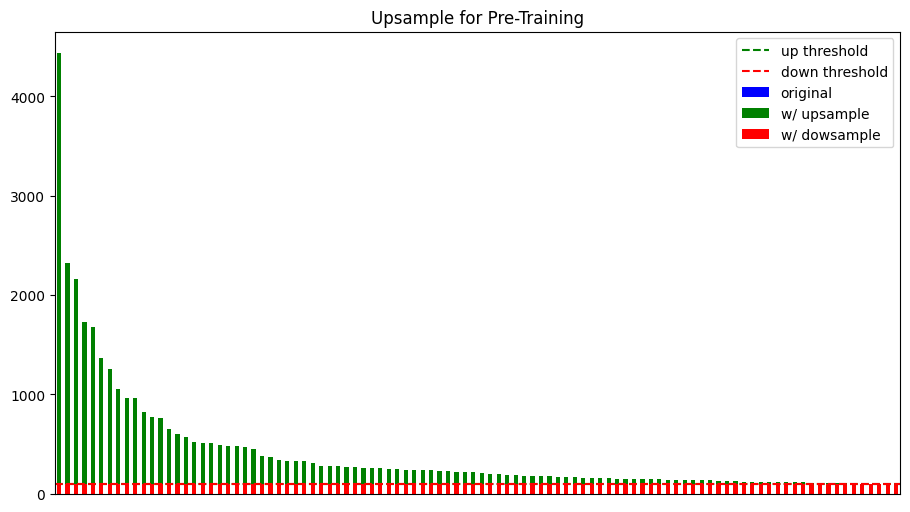

In [ ]:
pd.set_option('display.max_colwidth', 4000)
up_thr = 100
# s = order_dict(specie_size, 100)
# df = pd.DataFrame(s.items(), columns=['primary_label', 'file'])
# df = pd.DataFrame(data, columns=['primary_label', 'file'])
dn_df = downsample_data(train_df, thr=100)
up_df = upsample_data(train_df, thr=up_thr)
print(down_class)
print("# Pretraing Dataset")
print(f'> Original: {len(train_df)}')
print(f'> After Upsample: {len(up_df)}')
print(f'> After Downsample: {len(dn_df)}')

# Show effect of upsample

plt.figure(figsize=(12*2, 6))

ax1 = plt.subplot(1, 2, 1)
train_df.primary_label.value_counts()[:].plot.bar(color='blue', label='original')
up_df.primary_label.value_counts()[:].plot.bar(color='green', label='w/ upsample')
dn_df.primary_label.value_counts()[:].plot.bar(color='red', label='w/ dowsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.axhline(y=100, color='r', linestyle='--', label='down threshold')
plt.legend()
plt.title("Upsample for Pre-Training")
# plt.show()



In [ ]:
print(down_class)

for specie in down_class:
  n_specie = os.listdir('birds/dataset/out_augment/' + specie)
  for i in range(down_class[specie]):
    shutil.copy('birds/dataset/out_augment/' + specie+ "/" + n_specie[i], 'birds/balanced_dataset/train/' + specie)

In [ ]:
root = "drive/MyDrive/CIDL project"
species = os.listdir(os.path.join(root, 'birds', 'spectrograms'))
species.remove(".ipynb_checkpoints")
specie_size = {}
data = []
#species.remove("desktop.ini")
print("Number of species: ", len(species))
#print(species, '\n')

for specie in species:
    specie_folder = os.path.join(root, 'birds', 'spectrograms', specie)
    files = os.listdir(specie_folder)
    for file in files:

      #audios.remove("desktop.ini")
      specie_size[specie] = file
      data.append((specie, file))
      print("Specie", specie, "file", file)

Output streaming troncato alle ultime 5000 righe.
Specie thrnig1 file XC563366_26.png
Specie thrnig1 file XC658013_35.png
Specie thrnig1 file XC563366_27.png
Specie thrnig1 file XC658013_36.png
Specie thrnig1 file XC658013_37.png
Specie thrnig1 file XC563366_28.png
Specie thrnig1 file XC563366_29.png
Specie thrnig1 file XC563366_30.png
Specie thrnig1 file XC563366_31.png
Specie thrnig1 file XC658013_39.png
Specie thrnig1 file XC658013_40.png
Specie thrnig1 file XC658013_38.png
Specie thrnig1 file XC563366_32.png
Specie thrnig1 file XC658013_41.png
Specie thrnig1 file XC563366_34.png
Specie thrnig1 file XC563366_33.png
Specie thrnig1 file XC658013_42.png
Specie thrnig1 file XC658013_43.png
Specie thrnig1 file XC563366_35.png
Specie thrnig1 file XC658013_44.png
Specie thrnig1 file XC563366_36.png
Specie thrnig1 file XC658013_45.png
Specie thrnig1 file XC563366_37.png
Specie thrnig1 file XC658013_46.png
Specie thrnig1 file XC563366_38.png
Specie thrnig1 file XC658013_47.png
Specie thrnig1

#Utils

## Copy validation and test from full_dataset to dataset


In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
from_directory = "/content/drive/MyDrive/Marino_Matrella/birds/full_dataset/train/thrnig1"
to_directory = "/content/drive/MyDrive/Marino_Matrella/birds/dataset/augment/thrnig1"

copy_tree(from_directory, to_directory)

## Balanced dataset directory

In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
from_directory = "/content/drive/MyDrive/Marino_Matrella/birds/dataset"
to_directory = "/content/drive/MyDrive/Marino_Matrella/birds/balanced_dataset"

copy_tree(from_directory, to_directory)

## Copy train set in audio augmented

In [ ]:
from distutils.dir_util import copy_tree

# copy subdirectory example
from_directory = "/content/drive/MyDrive/Marino_Matrella/birds/dataset/train"
to_directory = "/content/drive/MyDrive/Marino_Matrella/birds/dataset/train_aug_spec"

copy_tree(from_directory, to_directory)

['/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC660170_30.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC372475_1.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC415653_0.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC372879_70.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC193331_1.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC139346_6.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC208462_9.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC376998_12.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC650663_13.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/XC740276_18.png',
 '/content/drive/MyDrive/CIDL project/birds/dataset/train_aug_spec/thrnig1/